**This Notebook has the best performing model for LSTM**


Architecture

4 Hidden Layers

2 Stacks of LSTM

#Imports

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


#Data Pipeline Functions

In [76]:
def data(filename):
  df = pd.read_csv(filename)
  df = df[['Date','Close']]
  df["Date"] = pd.to_datetime(df['Date'])
  return df

In [77]:
def split_data(stock_tr,stock_ts, lookback):
    data_raw_tr = stock_tr.to_numpy()
    data_tr = []
    for index in range(len(data_raw_tr) - lookback):
        data_tr.append(data_raw_tr[index: index + lookback])

    data_raw_ts = stock_ts.to_numpy()
    data_ts = []

    for index in range(len(data_raw_ts) - lookback):
        data_ts.append(data_raw_ts[index: index + lookback])

    data_tr = np.array(data_tr);
    data_ts = np.array(data_ts);

    x_train = data_tr[:,:-1,:]
    y_train = data_tr[:,-1,:]

    x_test = data_ts[:,:-1]
    y_test = data_ts[:,-1,:]

    return [x_train, y_train, x_test, y_test]

In [78]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [79]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#Load Data

In [80]:
main_df = data("/content/drive/MyDrive/STOCK PRICE PRED/NSE_train.csv")

In [81]:
test_df = data("/content/drive/MyDrive/STOCK PRICE PRED/NSE_test.csv")

In [82]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    51 non-null     datetime64[ns]
 1   Close   51 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 944.0 bytes


In [83]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    991 non-null    datetime64[ns]
 1   Close   991 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.6 KB


#Scale Features

In [84]:
price_train = main_df[['Close']]

scaler = MinMaxScaler(feature_range=(-1, 1))
price_train['Close'] = scaler.fit_transform(price_train['Close'].values.reshape(-1,1))
print(price_train.head())
print(price_train.shape)

price_test = test_df[['Close']]

scaler = MinMaxScaler(feature_range=(-1, 1))
price_test['Close'] = scaler.fit_transform(price_test['Close'].values.reshape(-1,1))
print(price_test.shape)

      Close
0 -0.354587
1 -0.340514
2 -0.348355
3 -0.381330
4 -0.372874
(991, 1)
(51, 1)


<ipython-input-84-4d2e8f9f7ed6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_train['Close'] = scaler.fit_transform(price_train['Close'].values.reshape(-1,1))
<ipython-input-84-4d2e8f9f7ed6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_test['Close'] = scaler.fit_transform(price_test['Close'].values.reshape(-1,1))


In [85]:
price_train

,Close
0,-0.354587
1,-0.340514
2,-0.348355
3,-0.381330
4,-0.372874
...,...
986,0.939401
987,0.952380
988,0.982503
989,1.000000


#Prepare Historical Dataset for LSTM training and testing

create a dataset that has historical value upto a week before, leading up to the current price

In [86]:
lookback = 7
X, y, X_test, y_test = split_data(price_train,price_test, lookback)
print('x_train.shape = ',X.shape)
print('y_train.shape = ',y.shape)
print('x_test.shape = ',X_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (984, 6, 1)
y_train.shape =  (984, 1)
x_test.shape =  (44, 6, 1)
y_test.shape =  (44, 1)


#Split into train-val

In [87]:
split_index = int(len(X) * 0.95)

X_train = X[:split_index]
X_val = X[split_index:]

y_train = y[:split_index]
y_val = y[split_index:]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((934, 6, 1), (50, 6, 1), (934, 1), (50, 1))

#Make torch tensors, make a Dataset and wrap in Data loaders

Wrap in torch tensors

In [88]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()

X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([934, 6, 1]),
 torch.Size([50, 6, 1]),
 torch.Size([934, 1]),
 torch.Size([50, 1]))

In [89]:
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_test.shape, y_test.shape

(torch.Size([44, 6, 1]), torch.Size([44, 1]))

Make a torch dataset

In [90]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
unseen_dataset = TimeSeriesDataset(X_test, y_test)

In [91]:
train_dataset

Wrap dataset in data loaders

In [92]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
unseen_loader = DataLoader(unseen_dataset, batch_size=batch_size, shuffle=False)

ex-visualisation

In [93]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 6, 1]) torch.Size([16, 1])


#LSTM

LSTM

In [179]:
#{'target': -0.00031288916943594813, 'params': {'dropout': 0.07005308235902165, 'learning_rate': 0.019810148908487882}}

In [397]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.dropout = dropout

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True, dropout=self.dropout if num_stacked_layers > 1 else 0)
        # Apply dropout only if there are more than one stacked layer

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1,4,2,0) #lstm with 4 hidden layers
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, num_layers=2, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [398]:
# train_loss = []
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)   #extracts the input features (x_batch) and target labels (y_batch) from the batch
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        model.to(torch.float32)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,avg_loss_across_batches))
            running_loss = 0.0
    avg_loss_across_batches_b = running_loss / len(train_loader)
    # print('Batch Loss: {0:.3f}'.format(avg_loss_across_batches_b))
    # train_loss.append(avg_loss_across_batches_b)

    print()

In [399]:
val_loss=[]
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(val_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        model.to(torch.float32)
        #no gradients since no updates
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss
    val_loss.append(avg_loss_across_batches)
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [400]:
  learning_rate = 0.01
  num_epochs = 25
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  for epoch in range(num_epochs):
      train_one_epoch()
      validate_one_epoch()

Epoch: 1

Val Loss: 0.652
***************************************************

Epoch: 2

Val Loss: 0.191
***************************************************

Epoch: 3

Val Loss: 0.048
***************************************************

Epoch: 4

Val Loss: 0.044
***************************************************

Epoch: 5

Val Loss: 0.030
***************************************************

Epoch: 6

Val Loss: 0.024
***************************************************

Epoch: 7

Val Loss: 0.016
***************************************************

Epoch: 8

Val Loss: 0.017
***************************************************

Epoch: 9

Val Loss: 0.016
***************************************************

Epoch: 10

Val Loss: 0.024
***************************************************

Epoch: 11

Val Loss: 0.021
***************************************************

Epoch: 12

Val Loss: 0.017
***************************************************

Epoch: 13

Val Loss: 0.026
**********************

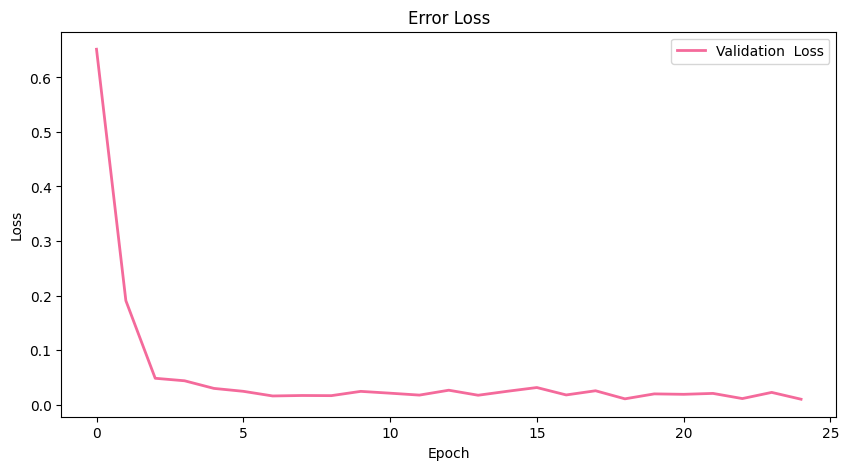

In [401]:
epochs = np.arange(num_epochs)
plt.figure(figsize=(10,5))
plt.plot(epochs, val_loss, color = '#f46a9b', linewidth=2, label = 'Validation  Loss')
plt.title('Error Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [402]:
from torchviz import make_dot

y = model(X_train)

In [351]:
make_dot(y.mean(), params=dict(model.named_parameters())).render("lstm_Bayesian", format="png")

'lstm_Bayesian.png'

#Training Predictions

In [403]:
with torch.no_grad():
  predicted = model(X_train.to(device)).detach().cpu().numpy().flatten()

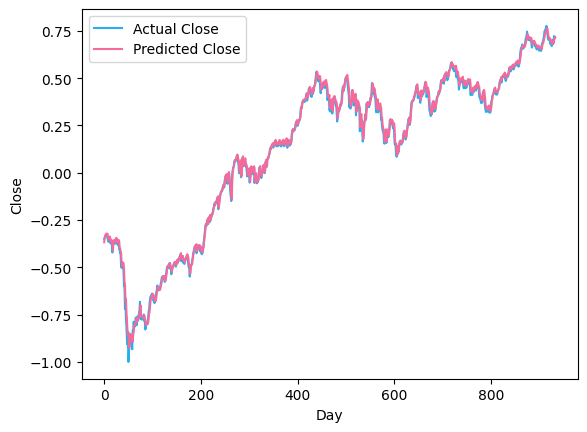

In [404]:
plt.plot(y_train, label='Actual Close',color = '#27aeef')
plt.plot(predicted, label='Predicted Close',color = '#f46a9b')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [405]:
train_predictions = predicted

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
# train_predictions

In [406]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
# new_y_train

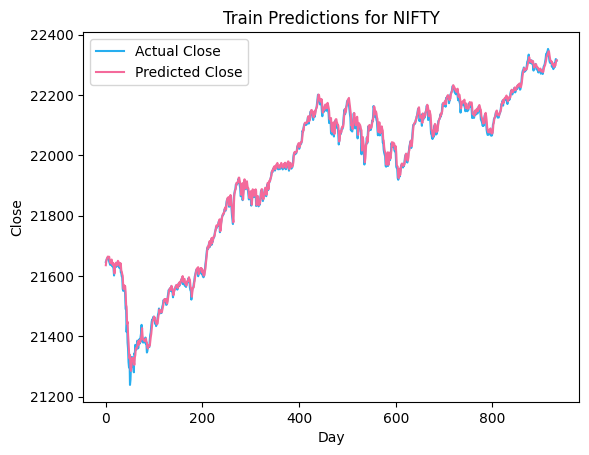

In [407]:
plt.plot(new_y_train, label='Actual Close',color = '#27aeef')
plt.plot(train_predictions, label='Predicted Close',color = '#f46a9b')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title("Train Predictions for NIFTY")
plt.legend()
plt.show()

In [408]:
train_predictions.shape

(934,)

In [409]:
new_y_train.shape

(934,)

In [410]:
rmse = np.sqrt(np.mean((train_predictions - new_y_train)**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 15.6278


#Validation Predictions

In [411]:
X_val.shape

torch.Size([50, 6, 1])

In [412]:
val_predictions = model(X_val.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_val.shape[0], lookback+1))
dummies[:, 0] = val_predictions
dummies = scaler.inverse_transform(dummies)

val_predictions = dc(dummies[:, 0])
val_predictions

array([22314.48705376, 22313.51090867, 22317.58862539, 22311.35377162,
       22307.21876658, 22301.52276703, 22285.41831758, 22271.6735336 ,
       22251.57445792, 22257.17693391, 22262.52236036, 22259.36338823,
       22253.46508463, 22260.86096172, 22268.22871818, 22280.13313361,
       22283.01404051, 22286.54131073, 22285.49793039, 22287.27798167,
       22288.82499065, 22301.60761507, 22309.61403158, 22310.61313687,
       22309.76173971, 22314.62425405, 22317.5656278 , 22317.94192829,
       22317.82495841, 22322.74734128, 22334.3641185 , 22339.59564141,
       22348.17385667, 22369.98724415, 22384.40886793, 22393.9766155 ,
       22397.14519801, 22402.1647691 , 22405.5110875 , 22403.25665005,
       22403.38992392, 22413.03859311, 22426.1922454 , 22430.05116712,
       22433.85983067, 22425.353338  , 22426.67306342, 22429.69491006,
       22433.5151285 , 22442.19565501])

In [413]:
dummies = np.zeros((X_val.shape[0], lookback+1))
dummies[:, 0] = y_val.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_val = dc(dummies[:, 0])
new_y_val

array([22312.27408677, 22319.3367044 , 22306.90293293, 22302.79373007,
       22295.52753698, 22272.42235774, 22258.28829738, 22234.82884299,
       22251.65515517, 22259.94879856, 22254.52001985, 22246.50990129,
       22259.27124827, 22267.89250455, 22283.93506616, 22283.48779098,
       22286.7468307 , 22282.47832742, 22285.13942967, 22286.75131804,
       22307.28813331, 22315.23632663, 22312.27857411, 22308.9309843 ,
       22316.84821501, 22319.36766702, 22318.49540375, 22317.84885347,
       22326.26197217, 22344.58496038, 22347.82189997, 22359.75525872,
       22396.85284809, 22411.75730919, 22419.07230206, 22415.83554944,
       22421.87972884, 22424.33276828, 22416.30047481, 22418.06717626,
       22440.76935536, 22465.0303227 , 22461.66504531, 22464.71587265,
       22437.8868405 , 22447.17678459, 22455.53231581, 22463.6752969 ,
       22482.5738981 , 22493.55078125])

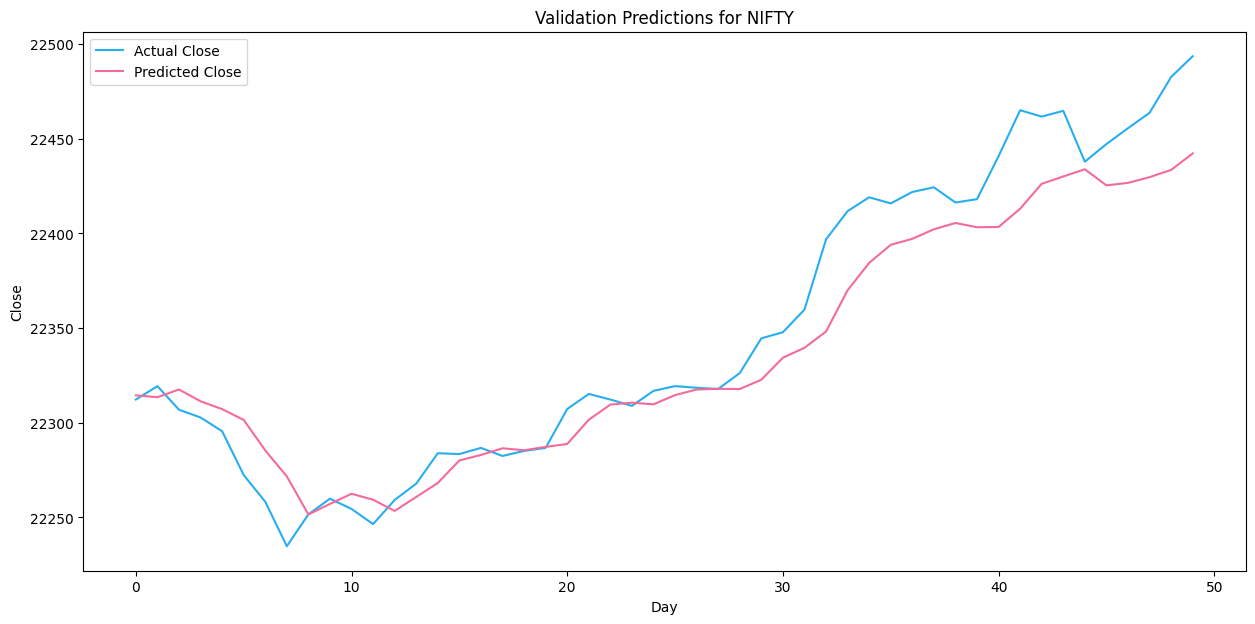

In [414]:
plt.figure(figsize=(15,7))
plt.plot(new_y_val, label='Actual Close',color = '#27aeef')
plt.plot(val_predictions, label='Predicted Close',color = '#f46a9b')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title("Validation Predictions for NIFTY")
plt.legend()
plt.show()

In [415]:
rmse = np.sqrt(np.mean((val_predictions - new_y_val)**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 23.2272


In [416]:
newdf=pd.DataFrame()
newdf["Actual"]=new_y_val
newdf["Predicted"]=val_predictions
newdf["Difference"]=newdf["Actual"]-newdf["Predicted"]

In [417]:
newdf

,Actual,Predicted,Difference
0,22312.274087,22314.487054,-2.212967
1,22319.336704,22313.510909,5.825796
2,22306.902933,22317.588625,-10.685692
3,22302.793730,22311.353772,-8.560042
4,22295.527537,22307.218767,-11.691230
5,22272.422358,22301.522767,-29.100409
6,22258.288297,22285.418318,-27.130020
7,22234.828843,22271.673534,-36.844691
8,22251.655155,22251.574458,0.080697
9,22259.948799,22257.176934,2.771865


#Unseen Data

In [418]:
X_test.shape

torch.Size([44, 6, 1])

In [419]:
unseen_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = unseen_predictions
dummies = scaler.inverse_transform(dummies)

unseen_predictions = dc(dummies[:, 0])
unseen_predictions

array([21536.92444357, 21542.47550217, 21619.96427311, 21652.49379215,
       21907.72605098, 22106.76211496, 22031.45489965, 21598.74598113,
       21487.89357024, 21624.33037594, 21374.22718854, 21426.47211605,
       21383.25825075, 21676.8728512 , 21543.43070636, 21703.02193981,
       21709.68708234, 21858.62983082, 21777.83733378, 21929.52403194,
       21941.37859121, 21714.26137885, 21780.77981067, 21637.31365906,
       21742.79314922, 21861.29430792, 21919.15981969, 22040.38475375,
       22114.07056379, 22177.87213822, 22070.45197821, 22195.44465694,
       22211.02786496, 22141.51791341, 22193.56397716, 21987.4399795 ,
       21991.40698056, 22280.83996377, 22340.13427127, 22336.54036412,
       22397.61719093, 22426.92218534, 22373.42278574, 22356.21527439])

In [420]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_unseen = dc(dummies[:, 0])
new_y_unseen

array([21544.8496019 , 21618.69921839, 21647.19922217, 21894.55078235,
       22097.44921067, 22032.30078113, 21571.9492204 , 21462.25001738,
       21622.40039156, 21238.80078125, 21453.94923165, 21352.59961414,
       21737.59960974, 21522.09959528, 21725.69921421, 21697.44921112,
       21853.80078102, 21771.69921948, 21929.40039182, 21930.49999941,
       21717.94922089, 21782.50000275, 21616.05077418, 21743.24999739,
       21840.05078168, 21910.75000105, 22040.6992225 , 22122.25000449,
       22196.9492232 , 22055.05078775, 22217.44920492, 22212.69921052,
       22122.05078548, 22198.34960848, 21951.15039101, 21982.8007849 ,
       22338.750003  , 22405.5996002 , 22356.30079553, 22474.05076489,
       22493.55078125, 22332.650405  , 22335.69921305, 21997.69921614])

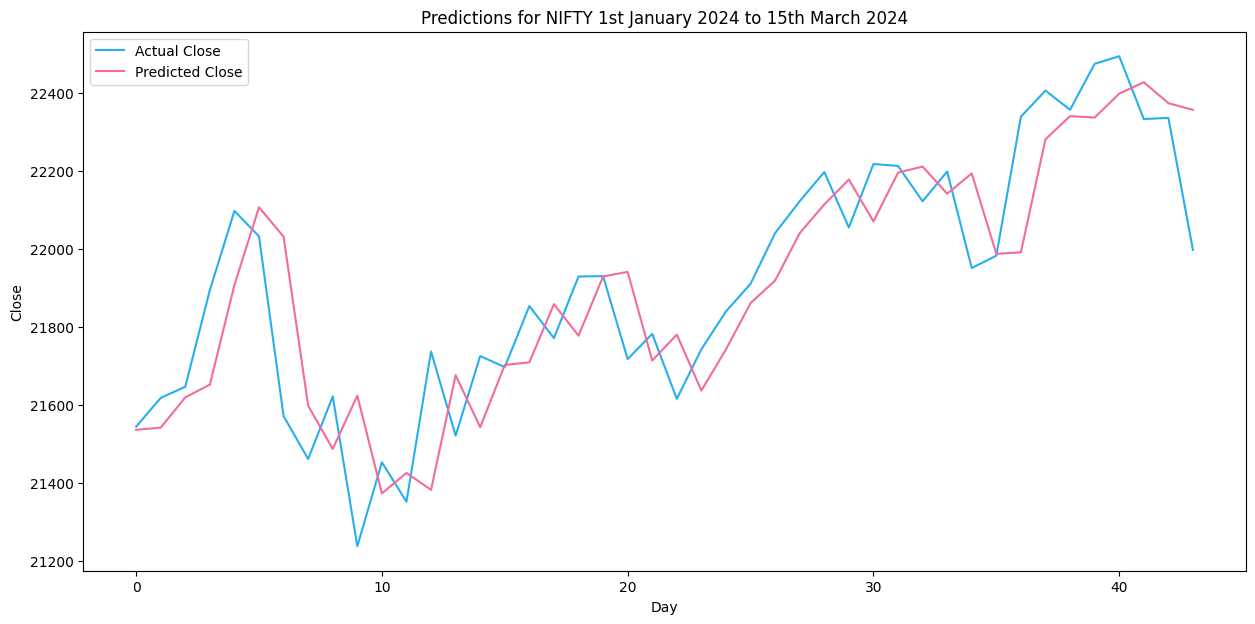

In [421]:
plt.figure(figsize=(15,7))
plt.plot(new_y_unseen, label='Actual Close',color = '#27aeef')
plt.plot(unseen_predictions, label='Predicted Close', color = '#f46a9b')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title("Predictions for NIFTY 1st January 2024 to 15th March 2024")
plt.legend()
plt.show()

In [422]:
rmse = np.sqrt(np.mean((unseen_predictions - new_y_unseen)**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 171.4020


In [423]:
neww=pd.DataFrame()
neww["Actual"]=new_y_unseen
neww["Predicted"]=unseen_predictions
neww["Difference"]=neww["Actual"]-neww["Predicted"]

In [424]:
neww

,Actual,Predicted,Difference
0,21544.849602,21536.924444,7.925158
1,21618.699218,21542.475502,76.223716
2,21647.199222,21619.964273,27.234949
3,21894.550782,21652.493792,242.056990
4,22097.449211,21907.726051,189.723160
5,22032.300781,22106.762115,-74.461334
6,21571.949220,22031.454900,-459.505679
7,21462.250017,21598.745981,-136.495964
8,21622.400392,21487.893570,134.506821
9,21238.800781,21624.330376,-385.529595


#Bayesian Optimisation

In [126]:
!pip install bayesian-optimization


In [342]:
import time
import statistics
from scipy.stats import zscore
from sklearn import metrics


In [343]:
SPLITS = 2
EPOCHS = 500
PATIENCE = 10
def evaluate_network(learning_rate, dropout):
    mean_benchmark = []
    epochs_needed = []

    model = LSTM(1,4,2, dropout=dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loader_train = train_loader

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        for batch_x, batch_y in loader_train:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            outputs_test = model(X_test)
            val_loss = criterion(outputs_test, y_test).item()

        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            epochs_needed.append(epoch)
            break

    running_loss = 0.0
    with torch.no_grad():
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

    avg_loss_across_batches = running_loss
    return -avg_loss_across_batches  # Minimize the loss, so negate it



In [344]:
from bayes_opt import BayesianOptimization
import time

# Supress NaN warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Bounded region of parameter space
pbounds = {'dropout': (0.0, 0.499),
           'learning_rate': (0.0, 0.1)
           }

optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start_time = time.time()
optimizer.maximize(init_points=10, n_iter=20)
time_took = time.time() - start_time

print(optimizer.max)

|   iter    |  target   |  dropout  | learni... |
-------------------------------------------------
| 1         | -0.001723 | 0.2081    | 0.07203   |
| 2         | -0.000465 | 5.707e-05 | 0.03023   |
| 3         | -0.000788 | 0.07323   | 0.009234  |
| 4         | -0.000337 | 0.09294   | 0.03456   |
| 5         | -0.00427  | 0.198     | 0.05388   |
| 6         | -0.001069 | 0.2092    | 0.06852   |
| 7         | -0.000377 | 0.102     | 0.08781   |
| 8         | -0.003023 | 0.01367   | 0.06705   |
| 9         | -0.00111  | 0.2082    | 0.05587   |
| 10        | -0.000312 | 0.07005   | 0.01981   |
| 11        | -0.003705 | 0.05428   | 0.03689   |
| 12        | -0.009041 | 0.4142    | 0.06601   |
| 13        | -0.000748 | 0.07104   | 0.01952   |
| 14        | -0.000529 | 0.06005   | 0.01616   |
| 15        | -0.003779 | 0.2221    | 0.05959   |
| 16        | -0.005629 | 0.443     | 0.04472   |
| 17        | -0.000326 | 0.09771   | 0.04619   |
| 18        | -0.000704 | 0.1071    | 0.03551   |
